# Загрузка Order book из CSV

In [2]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import metrics
#from sklearn.cross_validation import cross_val_score
#from sklearn.cross_validation import cross_val_predict
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
from alex.database import Database
from pprint import pprint
from statsmodels.tsa.stattools import adfuller # Расширенный тест Дики-Фуллера
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot

### Скоростная загрузка с диска, из заархивированного CSV-файла

In [2]:
# результат выполнения запроса:
# select * from tvf_get_order_book_snapshots(2880) where exchange='binance' and pair='ETH/USDT' # запрос на 20 минут
#order = pd.read_csv('tvf_get_order_book_snapshots 15.09.2018-01.10.2018.zip', index_col='dt')

In [3]:
# загрузка истории
# 15 секунд
db = Database()
sql_history = f"select * from v_history where exchange='binance' and pair='ETH/USDT' and dt>'2018-08-1'"
df_history = db.query(sql_history)
df_history.set_index('dt', inplace=True)

In [4]:
df_history.shape

(4318228, 11)

In [5]:
df_history.sort_values('dt').tail()

,rownum,id_ex_pair,exchange,pair,price,amount,type,side,id,location,insert_date
dt,,,,,,,,,,,
2018-10-19 08:59:59,12049246.0,19,binance,ETH/USDT,204.660004,2.70000,None,buy,39646396.0,memory,2018-10-19 08:59:59.9233333
2018-10-19 08:59:59,12049254.0,19,binance,ETH/USDT,204.649994,11.48605,None,buy,39646399.0,memory,2018-10-19 09:00:02.3666667
2018-10-19 08:59:59,12049253.0,19,binance,ETH/USDT,204.649994,0.97000,None,buy,39646398.0,memory,2018-10-19 09:00:02.3666667
2018-10-19 08:59:59,12049252.0,19,binance,ETH/USDT,204.649994,0.46606,None,buy,39646400.0,memory,2018-10-19 09:00:02.3666667
2018-10-19 08:59:59,12049251.0,19,binance,ETH/USDT,204.619995,3.99225,None,buy,39646397.0,memory,2018-10-19 09:00:02.3666667


In [8]:
interval = 60 #интервал подбирается в блокноте autocorrel_by_time

hist = df_history[['price', 'amount']].resample(str(interval)+'min').mean()

In [9]:
plt.rcParams['figure.figsize'] = [15, 7]

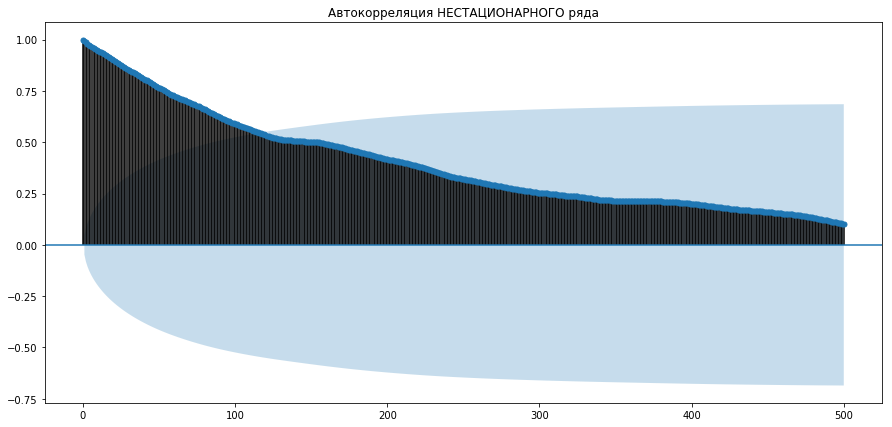

In [14]:
_ = plot_acf(hist[0:len(hist)].price.dropna(), lags=500, alpha=0.05)
_= plt.title("Автокорреляция НЕСТАЦИОНАРНОГО ряда")

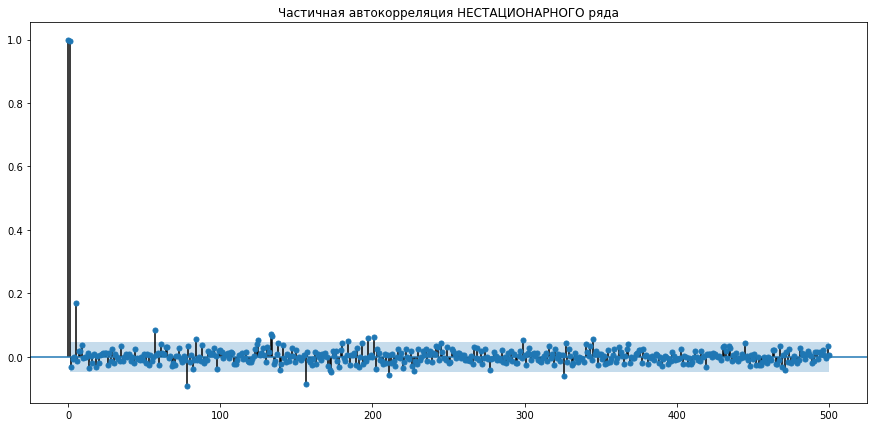

In [13]:
_ = plot_pacf(hist[0:len(hist)].price.dropna(), lags=500, alpha=0.05)
_= plt.title("Частичная автокорреляция НЕСТАЦИОНАРНОГО ряда")

#### http://people.duke.edu/~rnau/Notes_on_nonseasonal_ARIMA_models--Robert_Nau.pdf

i. If the ACF plot “cuts off sharply” at lag k (i.e., if the autocorrelation is significantly
different from zero at lag k and extremely low in significance at the next higher lag and
the ones that follow), while there is a more gradual “decay” in the PACF plot (i.e. if
the dropoff in significance beyond lag k is more gradual), then set q=k and p=0. This
is a so-called “MA(q) signature.”

ii. On the other hand, if the PACF plot cuts off sharply at lag k while there is a more
gradual decay in the ACF plot, then set p=k and q=0. This is a so-called “AR(p)
signature.”

iii. If there is a single spike at lag 1 in both the ACF and PACF plots, then set p=1 and q=0
if it is positive (this is an AR(1) signature), and set p=0 and q=1 if it is negative (this is
an MA(1) signature).


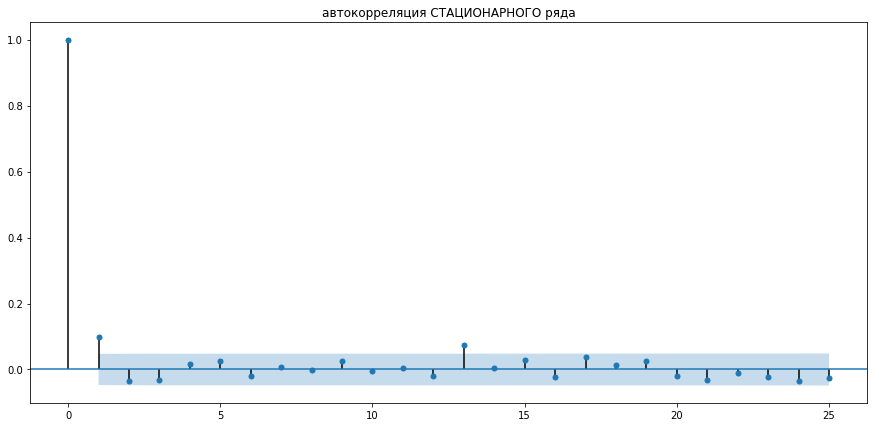

In [12]:
_ = plot_acf(hist[0:len(hist)].price.diff().dropna(), lags=25, alpha=0.05)
_= plt.title("автокорреляция СТАЦИОНАРНОГО ряда")

In [87]:
acf(hist[0:len(hist)].price.diff().dropna())

array([ 1.        ,  0.28264825, -0.13189055, -0.09790195,  0.02720792,
        0.08326905, -0.03405022, -0.09030027, -0.03491309,  0.01023235,
        0.02402924,  0.04606291, -0.0409851 , -0.12147536, -0.06835155,
       -0.02993079,  0.0094301 ,  0.07905981,  0.08859973,  0.06262082,
       -0.00607981, -0.02993445,  0.0044554 ,  0.01306577, -0.04034097,
       -0.01991716,  0.05143783,  0.0196419 ,  0.01883119,  0.00879972,
       -0.06409445, -0.00547509, -0.01782574, -0.0268759 , -0.04329892,
       -0.02894265,  0.02057638,  0.03110751,  0.03080711,  0.02060384,
        0.00107491])